In [10]:
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load the JSON data
with open("./results/text_pooling_results.json") as f:
    data = json.load(f)

# Function to flatten nested dictionary (dataset_params and model_params)
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Function to process the JSON data into a DataFrame
def process_data(data):
    rows = []
    for entry in data:
        # Flatten model_params and dataset_params and combine them
        flattened_params = {**flatten_dict(entry["model_params"]), **flatten_dict(entry["dataset_params"])}
        
        # Add train and validation metrics
        train_metrics = entry["train_metrics"]
        val_metrics = entry["val_metrics"]

        for epoch in range(entry["epochs"]):
            row = {
                'epoch': epoch + 1,
                'train_loss': train_metrics['loss'][epoch],
                'train_accuracy': train_metrics['accuracy'][epoch],
                'train_f1': train_metrics['f1'][epoch],
                'val_loss': val_metrics['loss'][epoch],
                'val_accuracy': val_metrics['accuracy'][epoch],
                'val_f1': val_metrics['f1'][epoch],
            }
            row.update(flattened_params)  # Include all flattened parameters in the row
            rows.append(row)
    
    df = pd.DataFrame(rows)
    # Convert unhashable types (lists, dictionaries, etc.) into strings for pivoting
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, dict, tuple))).any():
            df[col] = df[col].apply(lambda x: str(x))  # Convert to string
    
    return df

# Convert the JSON data to a DataFrame
df = process_data(data)

# Get all unique parameter names (excluding metric columns)
pivot_options = [col for col in df.columns if col not in ['epoch', 'train_loss', 'train_accuracy', 'train_f1', 'val_loss', 'val_accuracy', 'val_f1']]

# Create a Dash app for interactive plotting
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Model Training Metrics"),
    
    # Dropdown for selecting the metric to display
    html.Label("Choose a Metric:"),
    dcc.Dropdown(
        id="metric",
        options=[
            {'label': 'Loss', 'value': 'loss'},
            {'label': 'Accuracy', 'value': 'accuracy'},
            {'label': 'F1 Score', 'value': 'f1'},
        ],
        value='loss'
    ),
    
    # Dropdown for selecting the hyperparameter to pivot over (dynamic based on dataset)
    html.Label("Choose a Hyperparameter to Pivot Over:"),
    dcc.Dropdown(
        id="pivot_by",
        options=[{'label': str(col).replace('_', ' ').capitalize(), 'value': str(col)} for col in pivot_options],
        value='learning_rate'
    ),

    # Toggle to switch between individual, summary, and comparison view
    dcc.RadioItems(
        id='view_mode',
        options=[
            {'label': 'Individual', 'value': 'individual'},
            {'label': 'Summary', 'value': 'summary'},
            {'label': 'Comparison', 'value': 'comparison'}
        ],
        value='individual',
        labelStyle={'display': 'inline-block'}
    ),
    
    # Plot for training metrics
    dcc.Graph(id='train_metric_graph'),
    
    # Plot for validation metrics
    dcc.Graph(id='val_metric_graph')
])

@app.callback(
    [Output('train_metric_graph', 'figure'),
     Output('val_metric_graph', 'figure')],
    [Input('metric', 'value'),
     Input('pivot_by', 'value'),
     Input('view_mode', 'value')]
)
def update_graph(selected_metric, pivot_by, view_mode):
    train_metric_col = f"train_{selected_metric}"
    val_metric_col = f"val_{selected_metric}"

    if view_mode == 'summary':
        summary_df = df.groupby(['epoch', pivot_by]).agg(
            min_train_metric=(train_metric_col, 'min'),
            min_val_metric=(val_metric_col, 'min'),
        ).reset_index()

        # Prepare figure for training metrics
        train_fig = go.Figure()

        unique_pivot_vals = summary_df[pivot_by].unique()
        color_map = px.colors.qualitative.Plotly[:len(unique_pivot_vals)]

        for i, val in enumerate(unique_pivot_vals):
            pivot_group = summary_df[summary_df[pivot_by] == val]

            train_fig.add_trace(go.Scatter(
                x=pivot_group['epoch'],
                y=pivot_group['min_train_metric'],
                mode='lines',
                name=f'Min Train ({val})',
                line=dict(color=color_map[i], dash='dash')
            ))

        train_fig.update_layout(
            title=f"Train {selected_metric.capitalize()} Summary Over Epochs",
            xaxis_title="Epoch",
            yaxis_title=f"Train {selected_metric.capitalize()}"
        )

        # Prepare figure for validation metrics
        val_fig = go.Figure()

        for i, val in enumerate(unique_pivot_vals):
            pivot_group = summary_df[summary_df[pivot_by] == val]

            val_fig.add_trace(go.Scatter(
                x=pivot_group['epoch'],
                y=pivot_group['min_val_metric'],
                mode='lines',
                name=f'Min Val ({val})',
                line=dict(color=color_map[i], dash='dash')
            ))

        val_fig.update_layout(
            title=f"Validation {selected_metric.capitalize()} Summary Over Epochs",
            xaxis_title="Epoch",
            yaxis_title=f"Validation {selected_metric.capitalize()}"
        )

    elif view_mode == 'comparison':
        # Exclude columns that contain lists or unhashable types
        comparison_cols = [col for col in df.columns if col not in ['epoch', train_metric_col, val_metric_col, pivot_by] and not isinstance(df[col].iloc[0], list)]

        # Filter out cases where only the pivot_by value differs
        comparison_df = df.groupby(comparison_cols).filter(lambda x: x[pivot_by].nunique() > 1)

        train_fig = px.line(comparison_df, x="epoch", y=train_metric_col, color=pivot_by, markers=True,
                            labels={
                                "epoch": "Epoch",
                                train_metric_col: f"Train {selected_metric.capitalize()}",
                                pivot_by: pivot_by.replace("_", " ").capitalize()
                            },
                            title=f"Train {selected_metric.capitalize()} Comparison Over Epochs")
        
        val_fig = px.line(comparison_df, x="epoch", y=val_metric_col, color=pivot_by, markers=True,
                        labels={
                            "epoch": "Epoch",
                            val_metric_col: f"Validation {selected_metric.capitalize()}",
                            pivot_by: pivot_by.replace("_", " ").capitalize()
                        },
                        title=f"Validation {selected_metric.capitalize()} Comparison Over Epochs")


    else:  # Individual mode
        # Plot for training metrics (individual performance)
        train_fig = px.line(df, x="epoch", y=train_metric_col, color=pivot_by, markers=True,
                            labels={
                                "epoch": "Epoch",
                                train_metric_col: f"Train {selected_metric.capitalize()}",
                                pivot_by: pivot_by.replace("_", " ").capitalize()
                            },
                            title=f"Train {selected_metric.capitalize()} Over Epochs")
        
        # Plot for validation metrics (individual performance)
        val_fig = px.line(df, x="epoch", y=val_metric_col, color=pivot_by, markers=True,
                          labels={
                              "epoch": "Epoch",
                              val_metric_col: f"Validation {selected_metric.capitalize()}",
                              pivot_by: pivot_by.replace("_", " ").capitalize()
                          },
                          title=f"Validation {selected_metric.capitalize()} Over Epochs")

    return train_fig, val_fig

if __name__ == '__main__':
    app.run_server(debug=True)


# Static Plots

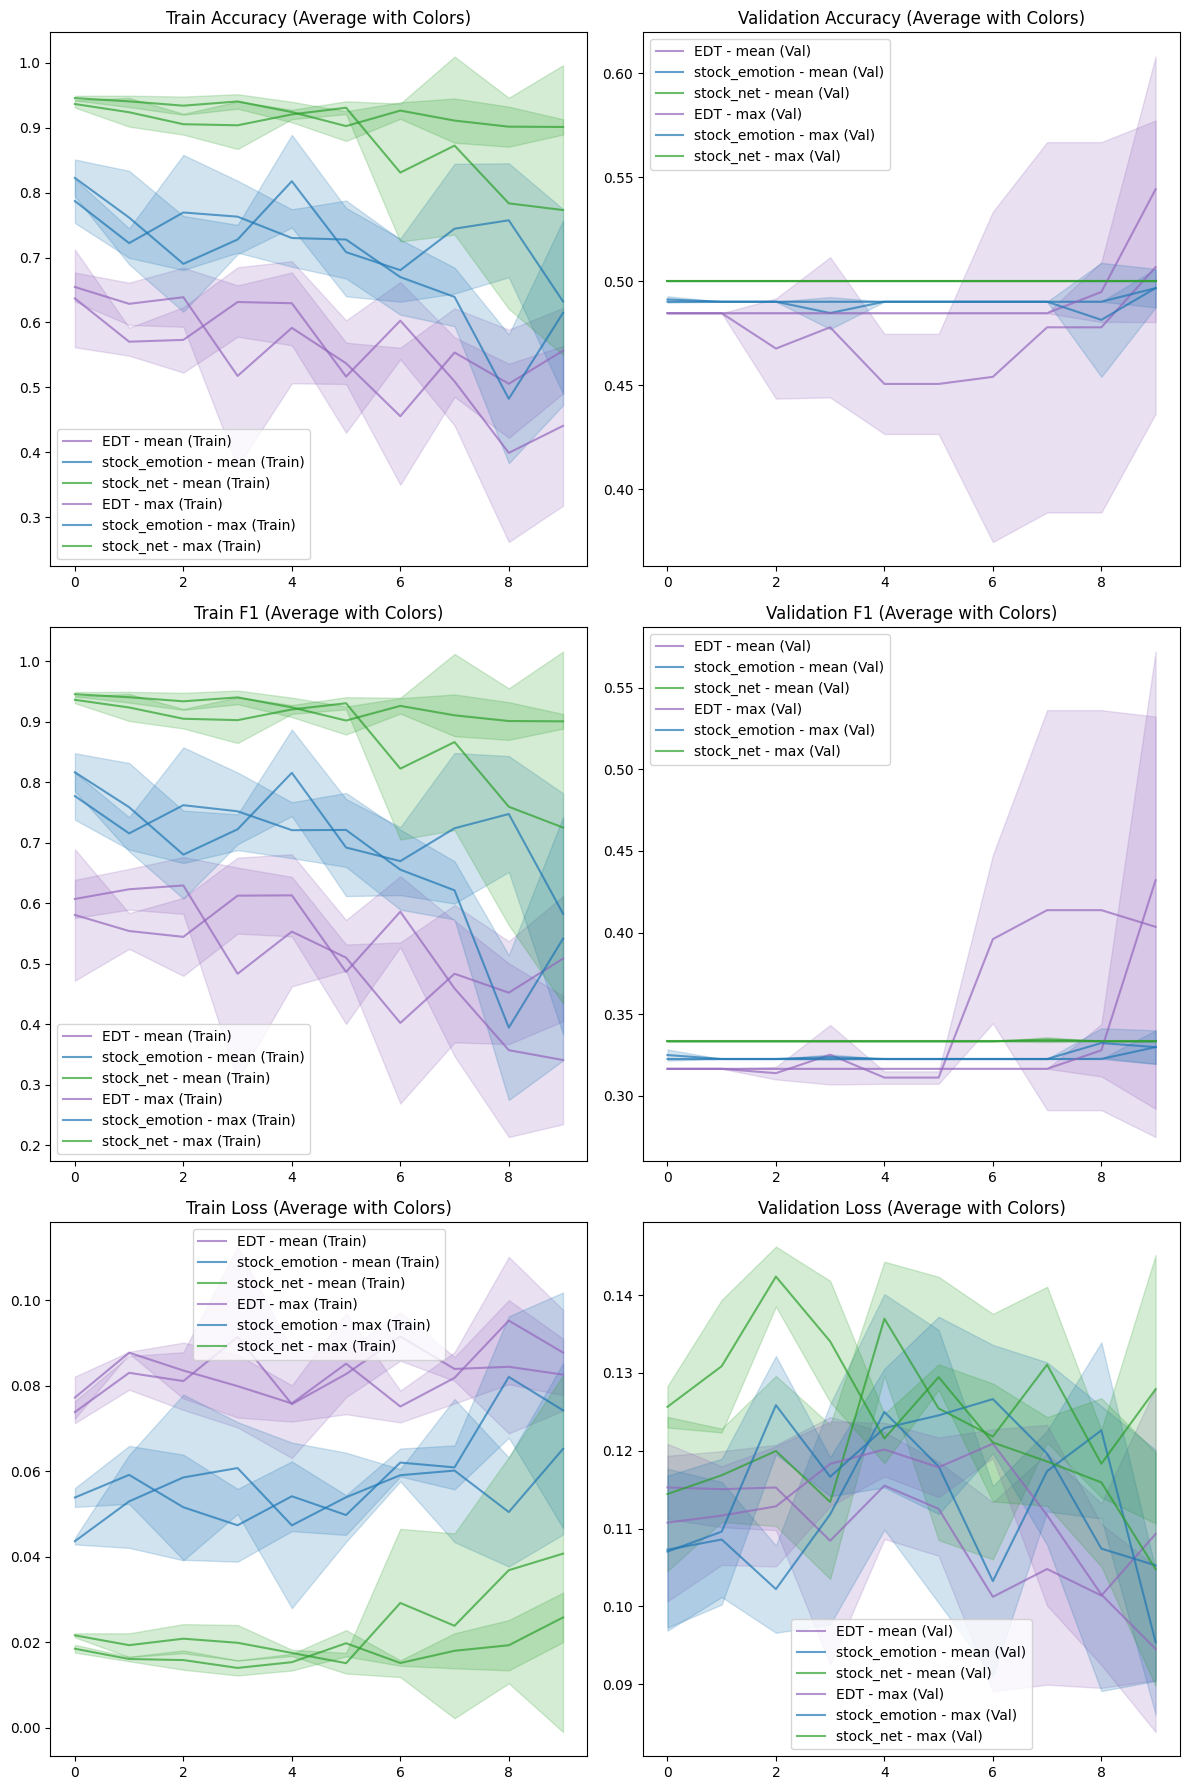

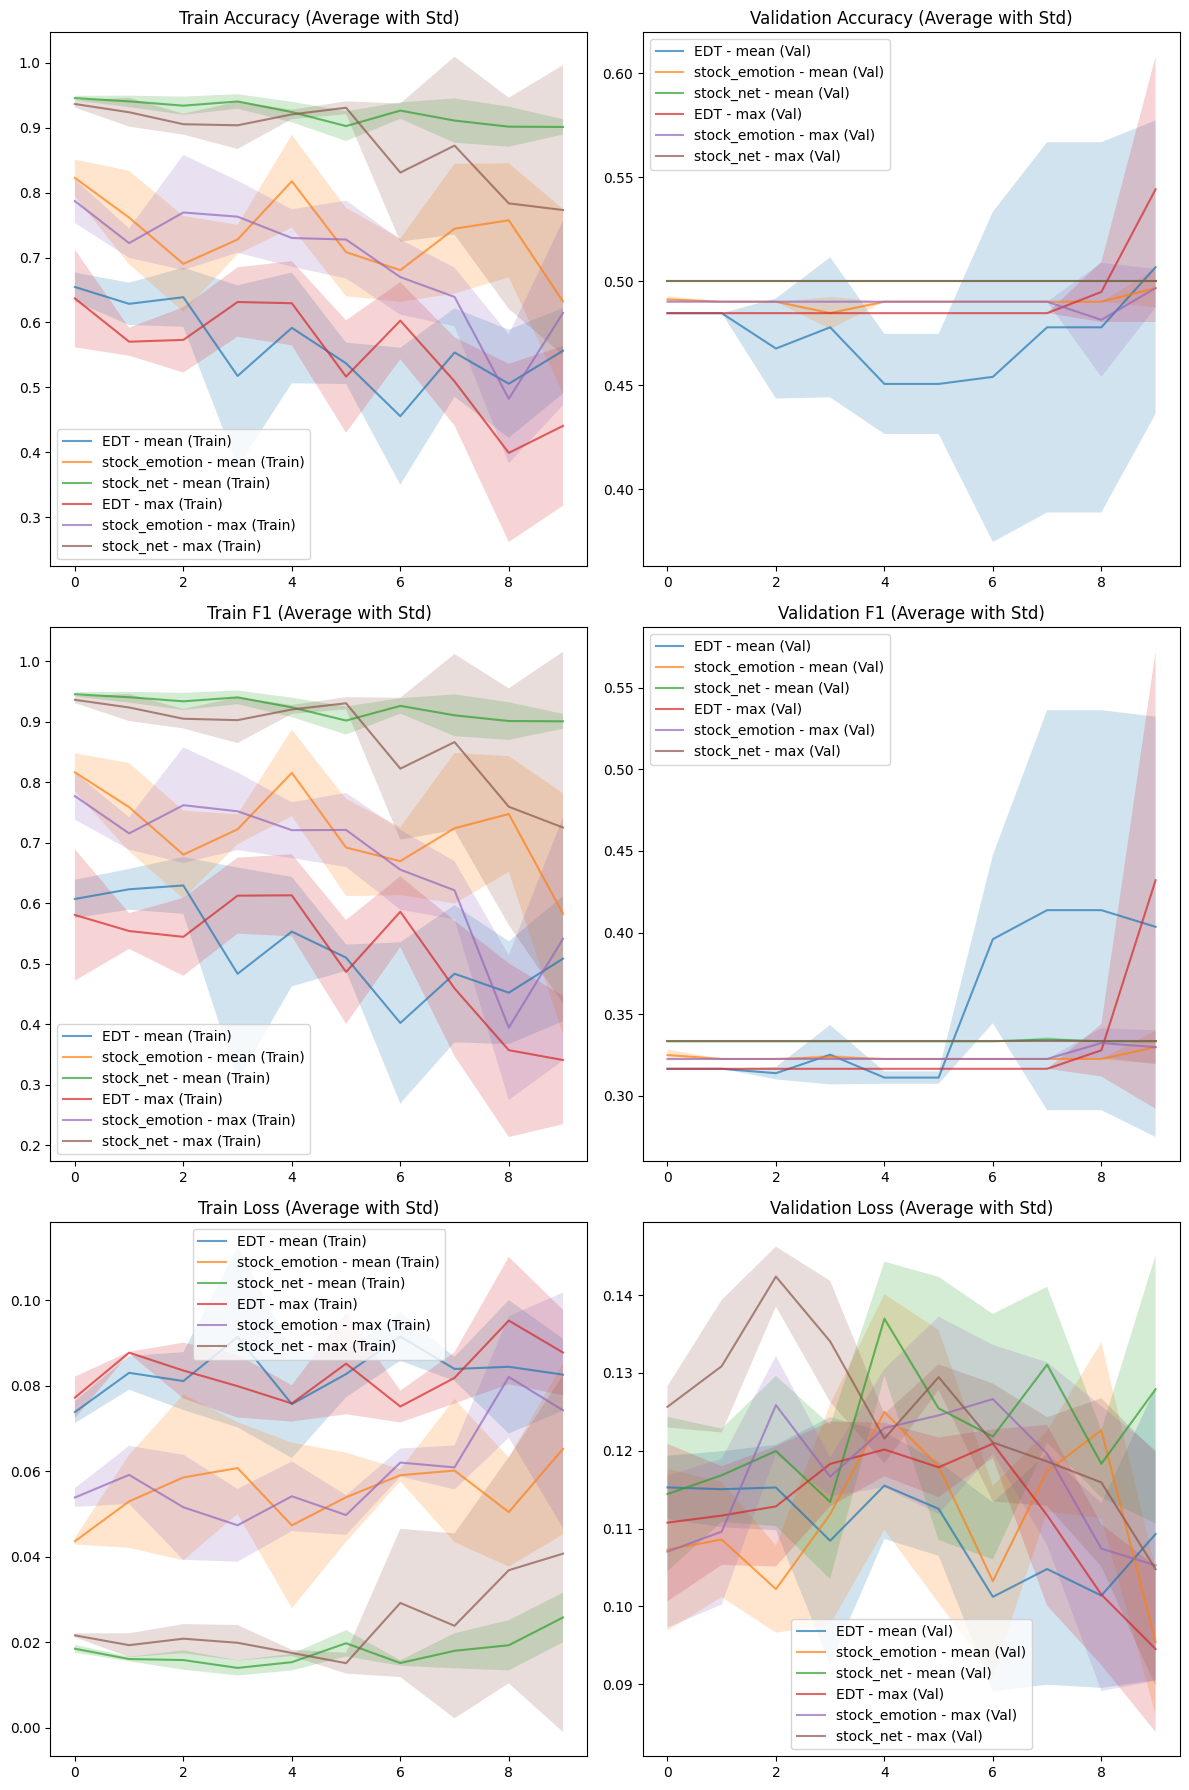

: 

In [17]:
# Updating the plotting function to include legend based on dataset_name and text_aggregation_method
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON file data
file_path = "./results/text_pooling_results.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Prepare a dataframe for performance metrics per search index
def extract_metrics(data):
    records = []
    for entry in data:
        search_index = entry['search_index']
        epochs = entry['epochs']
        train_acc = np.mean(entry['train_metrics']['accuracy'])
        val_acc = np.mean(entry['val_metrics']['accuracy'])
        train_loss = np.mean(entry['train_metrics']['loss'])
        val_loss = np.mean(entry['val_metrics']['loss'])
        train_f1 = np.mean(entry['train_metrics']['f1'])
        val_f1 = np.mean(entry['val_metrics']['f1'])
        records.append([search_index, epochs, train_acc, val_acc, train_loss, val_loss, train_f1, val_f1])
    
    return pd.DataFrame(records, columns=['search_index', 'epochs', 'train_accuracy', 'val_accuracy', 'train_loss', 'val_loss', 'train_f1', 'val_f1'])

# Create the metrics dataframe
metrics_df = extract_metrics(data)

# Plot Accuracy and Loss trends over epochs
def plot_trends(metrics_df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Accuracy trends
    sns.lineplot(x='epochs', y='train_accuracy', marker='o', data=metrics_df, ax=axes[0], label='Train Accuracy')
    sns.lineplot(x='epochs', y='val_accuracy', marker='o', data=metrics_df, ax=axes[0], label='Validation Accuracy')
    axes[0].set_title("Accuracy Trends")
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    # Loss trends
    sns.lineplot(x='epochs', y='train_loss', marker='o', data=metrics_df, ax=axes[1], label='Train Loss')
    sns.lineplot(x='epochs', y='val_loss', marker='o', data=metrics_df, ax=axes[1], label='Validation Loss')
    axes[1].set_title("Loss Trends")
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Visualize confusion matrices for training and validation
def plot_confusion_matrices(data):
    for i, entry in enumerate(data[:3]):  # Limiting to first 3 examples for demonstration
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        train_conf_matrix = np.array(entry['train_metrics']['conf_matrix'][-1])
        val_conf_matrix = np.array(entry['val_metrics']['conf_matrix'][-1])

        sns.heatmap(train_conf_matrix, annot=True, fmt='d', ax=ax[0], cmap='Blues')
        ax[0].set_title(f'Train Confusion Matrix (Index {entry["search_index"]})')
        ax[0].set_xlabel('Predicted')
        ax[0].set_ylabel('True')

        sns.heatmap(val_conf_matrix, annot=True, fmt='d', ax=ax[1], cmap='Blues')
        ax[1].set_title(f'Validation Confusion Matrix (Index {entry["search_index"]})')
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')

        plt.tight_layout()
        plt.show()

# Histogram of class predictions
def plot_class_prediction_distribution(data):
    for i, entry in enumerate(data[:3]):  # Limiting to first 3 examples
        train_conf_matrix = np.array(entry['train_metrics']['conf_matrix'][-1])
        val_conf_matrix = np.array(entry['val_metrics']['conf_matrix'][-1])

        # Calculate prediction distribution for each class
        train_class_dist = train_conf_matrix.sum(axis=0)
        val_class_dist = val_conf_matrix.sum(axis=0)

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.barplot(x=['Class 0', 'Class 1'], y=train_class_dist, ax=ax[0])
        ax[0].set_title(f'Train Class Distribution (Index {entry["search_index"]})')

        sns.barplot(x=['Class 0', 'Class 1'], y=val_class_dist, ax=ax[1])
        ax[1].set_title(f'Validation Class Distribution (Index {entry["search_index"]})')

        plt.tight_layout()
        plt.show()


# First, we will process the data to calculate the mean, variance, and standard deviation for runs with different random states.
def calculate_stats(data):
    # Collect unique dataset and model combinations based on search_index, excluding random state
    unique_runs = {}
    
    for entry in data:
        dataset_key = (
            entry['dataset_params']['data_source']['name'],
            entry['model_params']['ts_encoder']['name'],
            entry['model_params']['text_encoder']['name'],
        )
        
        if dataset_key not in unique_runs:
            unique_runs[dataset_key] = []
        
        unique_runs[dataset_key].append(entry)
    
    return unique_runs

# Calculate mean, variance, and standard deviation
def compute_run_stats(runs):
    stats = {}
    
    metrics = ['accuracy', 'f1', 'loss']
    
    for metric in metrics:
        train_values = np.array([entry['train_metrics'][metric] for entry in runs])
        val_values = np.array([entry['val_metrics'][metric] for entry in runs])
        
        stats[f'train_{metric}_mean'] = np.mean(train_values, axis=0)
        stats[f'train_{metric}_std'] = np.std(train_values, axis=0)
        stats[f'train_{metric}_var'] = np.var(train_values, axis=0)
        
        stats[f'val_{metric}_mean'] = np.mean(val_values, axis=0)
        stats[f'val_{metric}_std'] = np.std(val_values, axis=0)
        stats[f'val_{metric}_var'] = np.var(val_values, axis=0)
    
    return stats


def plot_metrics_with_custom_legend(data, show_average=False, mode='standard'):
    unique_runs = calculate_stats(data)
    
    for dataset_key, runs in unique_runs.items():
        fig, axes = plt.subplots(3, 2, figsize=(12, 18))
        
        if show_average:
            stats = compute_run_stats(runs)
            for i, metric in enumerate(['accuracy', 'f1', 'loss']):
                # Train metrics
                axes[i, 0].plot(stats[f'train_{metric}_mean'], label=f'Train {metric.capitalize()} (Mean)', color='b')
                axes[i, 0].fill_between(range(len(stats[f'train_{metric}_mean'])), 
                                        stats[f'train_{metric}_mean'] - stats[f'train_{metric}_std'],
                                        stats[f'train_{metric}_mean'] + stats[f'train_{metric}_std'], alpha=0.2, color='b')
                axes[i, 0].set_title(f'Train {metric.capitalize()} (Mean and Std)')
                axes[i, 0].legend()
                
                # Validation metrics
                axes[i, 1].plot(stats[f'val_{metric}_mean'], label=f'Val {metric.capitalize()} (Mean)', color='g')
                axes[i, 1].fill_between(range(len(stats[f'val_{metric}_mean'])), 
                                        stats[f'val_{metric}_mean'] - stats[f'val_{metric}_std'],
                                        stats[f'val_{metric}_mean'] + stats[f'val_{metric}_std'], alpha=0.2, color='g')
                axes[i, 1].set_title(f'Validation {metric.capitalize()} (Mean and Std)')
                axes[i, 1].legend()
                
        else:
            # Standard mode: Display all runs with a custom legend based on dataset_name and text_aggregation_method
            if mode == 'standard':
                for entry in runs:
                    dataset_name = entry['dataset_params']['data_source']['name']
                    text_agg_method = entry['model_params']['text_aggregation_method']
                    legend_label = f"{dataset_name} - {text_agg_method}"
                    
                    for i, metric in enumerate(['accuracy', 'f1', 'loss']):
                        axes[i, 0].plot(entry['train_metrics'][metric], label=f'{legend_label} (Train)', alpha=0.7)
                        axes[i, 0].set_title(f'Train {metric.capitalize()} (All Runs)')
                        axes[i, 0].legend()

                        axes[i, 1].plot(entry['val_metrics'][metric], label=f'{legend_label} (Val)', alpha=0.7)
                        axes[i, 1].set_title(f'Validation {metric.capitalize()} (All Runs)')
                        axes[i, 1].legend()
            
            # Best mode: Display the best run for each metric
            elif mode == 'best':
                best_entries = {}
                for metric in ['accuracy', 'f1', 'loss']:
                    if metric == 'loss':
                        best_entries[metric] = min(runs, key=lambda x: x['train_metrics'][metric][-1])
                    else:
                        best_entries[metric] = max(runs, key=lambda x: x['train_metrics'][metric][-1])
                
                for i, metric in enumerate(['accuracy', 'f1', 'loss']):
                    best_entry = best_entries[metric]
                    
                    dataset_name = best_entry['dataset_params']['data_source']['name']
                    text_agg_method = best_entry['model_params']['text_aggregation_method']
                    legend_label = f"{dataset_name} - {text_agg_method}"
                    
                    axes[i, 0].plot(best_entry['train_metrics'][metric], label=f'{legend_label} (Best Train)', color='b')
                    axes[i, 0].set_title(f'Train {metric.capitalize()} (Best Run)')
                    axes[i, 0].legend()

                    axes[i, 1].plot(best_entry['val_metrics'][metric], label=f'{legend_label} (Best Val)', color='g')
                    axes[i, 1].set_title(f'Validation {metric.capitalize()} (Best Run)')
                    axes[i, 1].legend()

        plt.tight_layout()
        plt.show()

# Running the updated plot function with custom legend
#plot_metrics_with_custom_legend(data, show_average=False, mode='standard')
#
# plot_metrics_with_custom_legend(data, show_average=True, mode='standard')
#
# plot_metrics_with_custom_legend(data, show_average=False, mode='best')

# Adjusting the average plot to average for models with same params but different random states and plot with variance shadows

# Applying the same distinct color variation logic to the average performance metrics plot
import matplotlib.colors as mcolors

# Function to generate a list of color variations based on a base color
def get_color_variations(base_color, num_variations):
    colors = list(mcolors.TABLEAU_COLORS.values())
    base_rgb = mcolors.hex2color(base_color)
    variations = [mcolors.to_hex(base_rgb)]
    for i in range(1, num_variations):
        # Slightly modify the brightness of the base color to generate variations
        variation = [min(1, max(0, base_rgb[j] + (i * 0.2 / num_variations))) for j in range(3)]
        variations.append(mcolors.to_hex(variation))
    return variations

# Base colors for the datasets
color_mapping = {
    'stock_net': '#2ca02c',  # Base green
    'EDT': '#9467bd',        # Base purple
    'stock_emotion': '#1f77b4'  # Base blue
}

def plot_metrics_with_custom_average_colors(data):
    # Group runs by dataset_name and text_aggregation_method
    unique_runs = {}
    
    for entry in data:
        dataset_name = entry['dataset_params']['data_source']['name']
        text_agg_method = entry['model_params']['text_aggregation_method']
        run_key = (dataset_name, text_agg_method)
        
        if run_key not in unique_runs:
            unique_runs[run_key] = []
        
        unique_runs[run_key].append(entry)
    
    # Plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    
    for run_key, runs in unique_runs.items():
        dataset_name, text_agg_method = run_key
        legend_label = f"{dataset_name} - {text_agg_method}"
        
        # Get color variations based on the dataset
        color_variations = get_color_variations(color_mapping[dataset_name], len(runs))
        
        # Calculate mean and variance across runs with different random states
        stats = compute_run_stats(runs)
        
        for i, metric in enumerate(['accuracy', 'f1', 'loss']):
            color = color_variations[0]  # All runs for the same key should have the same color in average mode
            
            # Train metrics
            axes[i, 0].plot(stats[f'train_{metric}_mean'], label=f'{legend_label} (Train)', color=color, alpha=0.7)
            axes[i, 0].fill_between(range(len(stats[f'train_{metric}_mean'])), 
                                    stats[f'train_{metric}_mean'] - stats[f'train_{metric}_std'],
                                    stats[f'train_{metric}_mean'] + stats[f'train_{metric}_std'], alpha=0.2, color=color)
            axes[i, 0].set_title(f'Train {metric.capitalize()} (Average with Colors)')
            axes[i, 0].legend()
            
            # Validation metrics
            axes[i, 1].plot(stats[f'val_{metric}_mean'], label=f'{legend_label} (Val)', color=color, alpha=0.7)
            axes[i, 1].fill_between(range(len(stats[f'val_{metric}_mean'])), 
                                    stats[f'val_{metric}_mean'] - stats[f'val_{metric}_std'],
                                    stats[f'val_{metric}_mean'] + stats[f'val_{metric}_std'], alpha=0.2, color=color)
            axes[i, 1].set_title(f'Validation {metric.capitalize()} (Average with Colors)')
            axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Running the updated average plot function with color variations for each dataset
plot_metrics_with_custom_average_colors(data)


# Running the updated average plot function
#plot_metrics_with_custom_average(data)
